# kaBLOOM! app workflow

This is a demo of the code I used to label poppy blooms for the kaBLOOM! web app. Steps 0-3 outline the active labeling process - in step 0 I hand label a small number of pixels with which to seed the initial model, and then steps 1-3 are repeated several times to iteratively improve the model. In steps 4 and 5 the labeled images are segmented and prepared for use by the app.

Please note that there are several differences between this demo and the actual code used for the app. First, for brevity I have omitted the code related to downloading the images from the satellite API (this code can be found in the github repository in the notebook get_data). Second, I have also omitted the bulk of the exploratory data analysis as well as model exploration and selection (code for these can also be found in the github repository). Third, here I show the pipeline using a single image. In reality, the model was built using 6 images from 3 different locations, and was used to predict blooms in 82 images from 3 locations over a 4 year period. And finally, here I only show 2 iterations of the active learning cycle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

In [2]:
#load files to train model on
antelope_bloom = np.load('/home/esther/shared/2019-03-30_antelope.npy')
antelope_nobloom = np.load('/home/esther/shared/2019-03-10_antelope.npy')

In [3]:
#initialize index arrays to keep track of pixel labels
antelope_bloom_labels = np.full(antelope_bloom[:,:,0].shape, None, dtype=float)
antelope_nobloom_labels = np.full(antelope_nobloom[:,:,0].shape, None, dtype=float)

## Step 0: Hand label a subset of pixels as either poppy or not poppy

#### 0.0 First define some functions for visualization and for keeping track of labelled pixels

In [4]:
#plots image

def show_image(img):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    
    #plot true color image (saturated to emphasize orange color)
    rgb = ax[0].imshow(np.minimum(img[:, :, [3,2,1]] * 5, 1)) #slightly saturated to aid in visualization
    
    #plot red channel only
    ch4 = ax[1].imshow(np.minimum(img[:, :, 3] * 5, 1))
    
    ax[0].grid()
    ax[1].grid()
    
    ax[0].title.set_text('True color')
    ax[1].title.set_text('Red channel only')
    
    return fig, ax

In [5]:
#plots subsets of image

def show_subsets(subsets, threshs):
    
    n = len(subsets)
    
    fig, axs = plt.subplots(nrows=3, ncols=n, figsize=(15, 10))
    
    for i, (subset, thresh) in enumerate(zip(subsets, threshs)):
        
        #get rgb and channel 4 for images
        subset_rgb = subset[:, :, [3,2,1]]
        subset_ch4 = subset[:, :, 3]
        
        #get thresholded image
        tmp = np.zeros(subset_ch4.shape)
        tmp[subset_ch4 > thresh] = subset_ch4[subset_ch4 > thresh]

        #plot true color subsets (saturated to emphasize orange color)
        rgb = axs[0, i].imshow(np.minimum(subset_rgb * 5, 1)) #slightly saturated to aid in visualization
        axs[0, i].title.set_text('True color')
        
        #plot red channel only
        ch4 = axs[1, i].imshow(subset_ch4)
        axs[1, i].title.set_text('Red channel only')
        
        #plot thresholded image
        th = axs[2, i].imshow(tmp)
        axs[2, i].title.set_text('Red channel thresholded')
        
        #add colorbars
        fig.colorbar(rgb, ax=axs[0, i])
        fig.colorbar(ch4, ax=axs[1, i])
        fig.colorbar(th, ax=axs[2, i])


In [6]:
#gets n random pixels from no-bloom image and updates the label index array

def get_neg(idx_arr, n):
    
    #get index values for each pixel
    idx = [index for index in np.ndindex(idx_arr.shape)]
    
    #randomly shuffle order and select the top n indices
    rng = np.random.default_rng(seed=1) #don't change the seed on subsequent iterations
    rng.shuffle(idx)
    idx = idx[0:n]
    
    #for each pixel selected update the label index array
    for i in idx:
        idx_arr[i] = 0
        
    return idx_arr

#### 0.1 Next, visualize the area to get a sense of where there are poppies. The red channel will be helpful for thresholding, so visualize that as well.

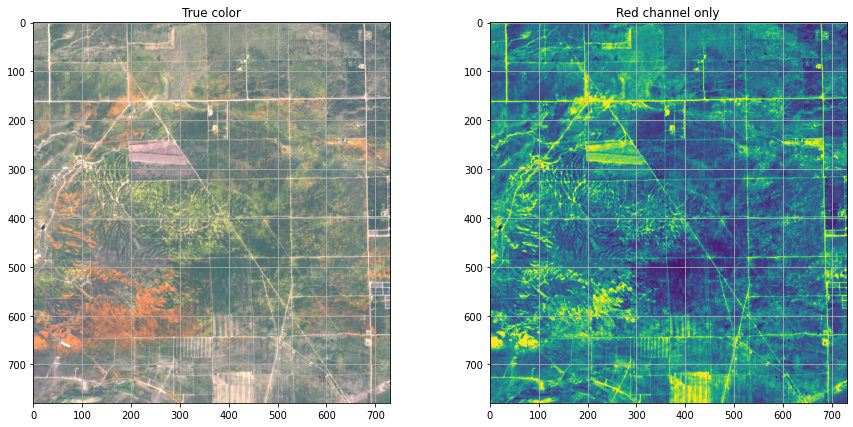

In [7]:
fig, ax = show_image(antelope_bloom)

#### 0.2 Now choose a few areas that clearly have poppies in them and visualize. Play around with different thresholding levels in the red channel so that only definite poppy pixels are above the threshold. I've plotted the final thresholds here.

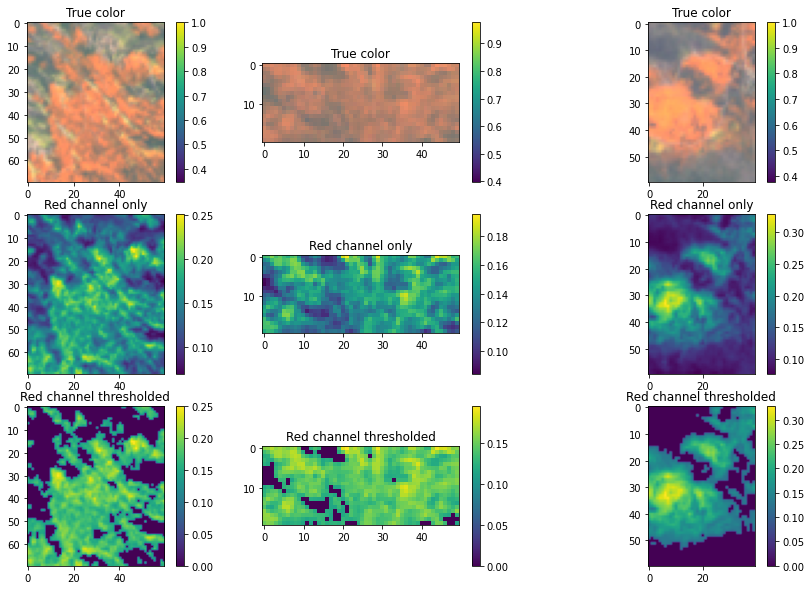

In [8]:
#define subset areas and subset area thresholds
subset1 = antelope_bloom[530:600, 200:260, :]
subset2 = antelope_bloom[610:630, 150:200, :]
subset3 = antelope_bloom[620:680, 0:40, :]
subsets_antelope = [subset1, subset2, subset3]
threshs_antelope = [0.14, 0.115, 0.12]

#visualize
show_subsets(subsets_antelope, threshs_antelope)

#### 0.3 Keep track of which pixels were labelled as poppy pixels. To do this I set the corresponding pixels in the index array to 1 (the rest of the pixels are set to nan for now).

In [9]:
#update label index array
tmp1 = antelope_bloom[:,:,3] > threshs_antelope[0]
tmp2 = antelope_bloom[:,:,3] > threshs_antelope[1]
tmp3 = antelope_bloom[:,:,3] > threshs_antelope[2]
antelope_bloom_labels[530:600, 200:260] = tmp1[530:600, 200:260]
antelope_bloom_labels[610:630, 150:200] = tmp2[610:630, 150:200]
antelope_bloom_labels[620:680, 0:40] = tmp3[620:680, 0:40]
antelope_bloom_labels[antelope_bloom_labels==0] = None

#### 0.4 Now visualize the image of the same region but from before poppy season.

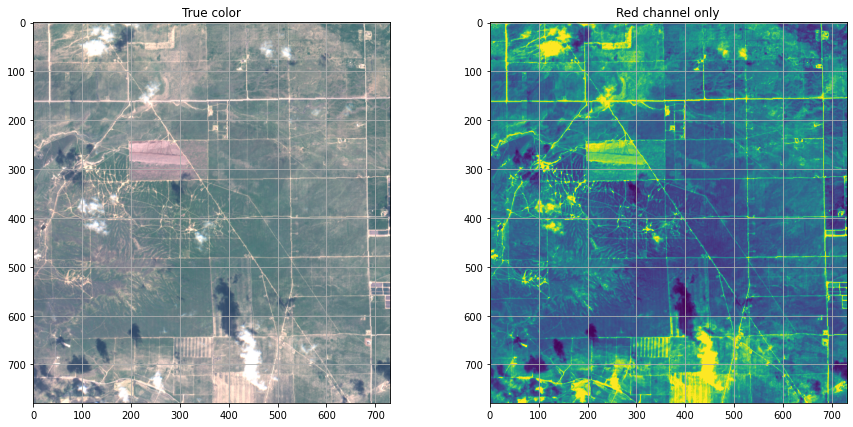

In [10]:
fig, ax = show_image(antelope_nobloom)

#### 0.5 Now label a random assortment of pixels from pre-poppy season image. To do this, first get the number of pixels labelled as poppy, then get three times that amount of random pixels from the pre-poppy season image. (This is too roughly recreate the balance of poppy/not-poppy in a bloom image).

In [11]:
#get number of pixels labelled as poppy
n_antelope = np.count_nonzero(~np.isnan(antelope_bloom_labels))

#generate label index array of randomly labelled pixels from no-poppy image
antelope_nobloom_labels = get_neg(antelope_nobloom_labels, n_antelope*3)

#### Step 0 conclusion

I now have two index arrays, one has pixels labelled as poppy (antelope_bloom_labels) and it corresponds to an image of Antelope Valley during a bloom (antelope_bloom), and the other has pixels labelled as not poppy (antelope_nobloom_labels) and it corresponds to an image of Antelope Valley when there is no bloom (antelope_nobloom). In future steps, both the bloom and nobloom images will have pixels that are labelled as poppy as well as pixels labelled as not poppy. The aim is to correctly identify poppy and not poppy pixels in the bloom image, and to minimize the number of pixels lablled as poppy in the nobloom image (because those are false positives).

## Step 1: Fit a classifier to the labelled pixels.

### This is the first step in the active learning cycle.

Note, for brevity I have not included here the process of how I chose the model to use, but this code is available in the github repository in the notebook named model_exploration. In short, I started with five classifiers and tested them all using their out-of-the-box parameters. I went with the random forest classifier because it performed best and it generalized best to unseen data. The other four classifiers that I tried were logistic regression, naive bayes, gradient boosting, and stochastic gradient descent.

#### 1.0 Define function

In [12]:
#pulls data from labelled pixels out of array and formats for input to model

def get_pixdata(idx_arr, img):
    
    #get row and column indices of labelled pixels
    idx_row_poppy, idx_col_poppy = np.nonzero(idx_arr==1)
    idx_row_nopoppy, idx_col_nopoppy = np.nonzero(idx_arr==0)

    #preallocate array to store pixel data
    pix_data_poppy = np.random.random((len(idx_row_poppy),13))
    pix_data_nopoppy = np.random.random((len(idx_row_nopoppy),13))

    #pull out all 13 channels for each poppy pixel and put into array
    for i, (row, col) in enumerate(zip(idx_row_poppy, idx_col_poppy)):
        pix_data_poppy[i, :] = img[row, col, :]
    
    #do same for no-poppy pixels
    for i, (row, col) in enumerate(zip(idx_row_nopoppy, idx_col_nopoppy)):
        pix_data_nopoppy[i, :] = img[row, col, :]
        
    return pix_data_poppy, pix_data_nopoppy

#### 1.1 For each labelled pixel, extract data from all 13 satellite channels.

These will be the features fed to the classifier.

In [13]:
#get data from pixels labelled during initialization phase (Step 0)

#bloom image
poppy_pixdata, tmp = get_pixdata(antelope_bloom_labels, antelope_bloom)

#no bloom image
tmp, nopoppy_pixdata = get_pixdata(antelope_nobloom_labels, antelope_nobloom)

#sanity check
print(poppy_pixdata.shape)
print(nopoppy_pixdata.shape)

(4906, 13)
(14718, 13)


#### 1.2 Prepare data for use in random forest classifier.

In [14]:
#get features and labels
X = np.vstack((poppy_pixdata, nopoppy_pixdata))
y = np.concatenate( ( np.ones(poppy_pixdata.shape[0]), np.zeros(nopoppy_pixdata.shape[0]) ) )

In [15]:
#test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [16]:
#fit scaler to training data and scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

#apply same transformation to test data
X_test = scaler.transform(X_test)

#### 1.3 Train and test random forest classifier model.

In [17]:
#initialize model and fit to training data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
clf_rf = clf_rf.fit(X_train, y_train);

In [18]:
#look at mean precision score
score_rf = clf_rf.score(X_test, y_test)
print(score_rf)

0.9964331210191083


In [19]:
#predict test data
y_pred_rf = clf_rf.predict(X_test)

In [20]:
#precision, recall and f-scores for each class
prf_rf = precision_recall_fscore_support(y_test, y_pred_rf, average=None)
print(prf_rf)

(array([0.99523323, 1.        ]), array([1.        , 0.98602794]), array([0.99761092, 0.99296482]), array([2923, 1002]))


In [21]:
# look at importance of each feature
importances = clf_rf.feature_importances_
importances

array([0.35066648, 0.22693325, 0.01788161, 0.07741931, 0.12046055,
       0.01360692, 0.00773788, 0.0092302 , 0.03321947, 0.01985522,
       0.08002911, 0.02247449, 0.0204855 ])

#### Step 1 conclusion

The first step of the first iteration returns a model with almost perfect precision because I have fed it data that is very clearly separable, and because it is perfectly overfit. This is ok for the first iteration.

## Step 2: Predict the rest of the pixels in the image and evaluate predictions.

#### This is the second step in the active learning cycle.

#### 2.0 Define functions

In [22]:
#predicts label of all pixels in an image

def predict_pixels_probas(img, scaler):
    
    #copy image array and reshape so channels are columns and pixels are rows
    img_copy = np.copy(img)
    img_copy = np.reshape(img_copy, (-1,13))
    
    #scale
    img_copy = scaler.transform(img_copy)
    
    #predict all the pixels and reshape for visualization
    preds = clf_rf.predict(img_copy)
    preds = np.reshape(preds, img[:,:,0].shape)
    
    #get prediction probability for all the pixels
    probas = clf_rf.predict_proba(img_copy)
    
    #reshape prediction that its a poppy - for visualization
    probas = np.reshape(probas[:,1], img[:,:,0].shape)
    
    return preds, probas

In [23]:
#plots visual check of predictions

def visual_check(preds, probas, img):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    axs[0].imshow(preds)
    axs[1].imshow(np.minimum(img[:, :, [3,2,1]] * 5, 1))
    a = axs[2].imshow(probas)
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    axs[0].title.set_text('Prediction')
    axs[1].title.set_text('True color')
    axs[2].title.set_text('Poppy probability')
    
    fig.colorbar(a,ax=axs[2])

In [24]:
#looks at pixels with predictions between specified probability values

def plot_thresh(probas, thresh1, thresh2, img, coords=''):
    
    if coords=='':
        y1 = 0
        x1 = 0
        y2 = img.shape[0]
        x2 = img.shape[1]
    else:
        y1,y2,x1,x2 = coords
    
    fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

    #threshold prediction probabilities
    probas_thresh = np.copy(probas)
    probas_thresh[probas_thresh < thresh1] = 0
    probas_thresh[probas_thresh > thresh2] = 0
    probas_thresh[probas_thresh > 0] = 1
    
    axs[0].imshow(probas_thresh[y1:y2, x1:x2])
    axs[1].imshow(np.minimum(img[y1:y2, x1:x2, [3,2,1]] * 5, 1))

    axs[0].grid()
    axs[1].grid()
    
    return probas_thresh

#### 2.1 Use current model to predict class of all pixels in the image, then visualize predictions and prediction probabilities

In [25]:
antelope_bloom_preds, antelope_bloom_probas = predict_pixels_probas(antelope_bloom, scaler)

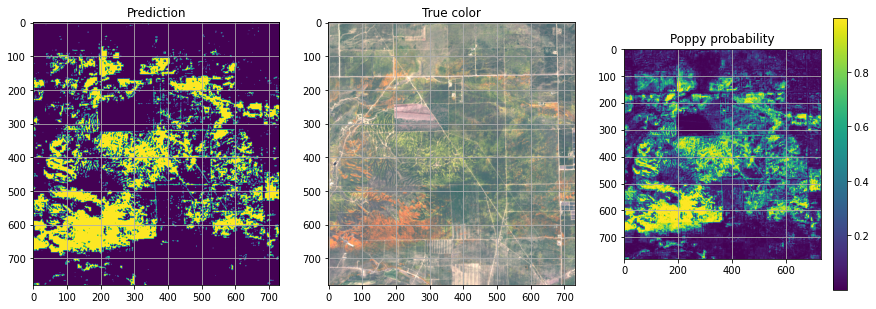

In [26]:
visual_check(antelope_bloom_preds, antelope_bloom_probas, antelope_bloom)

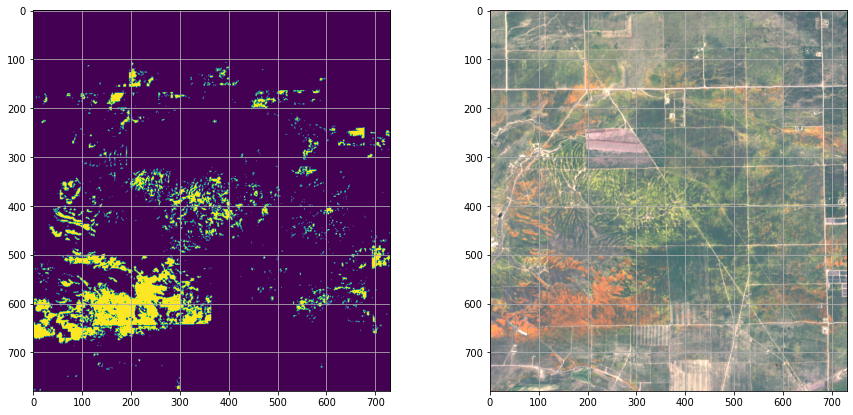

In [27]:
#look at definitely positive pixels
plot_thresh(antelope_bloom_probas, 0.9, 1, antelope_bloom);

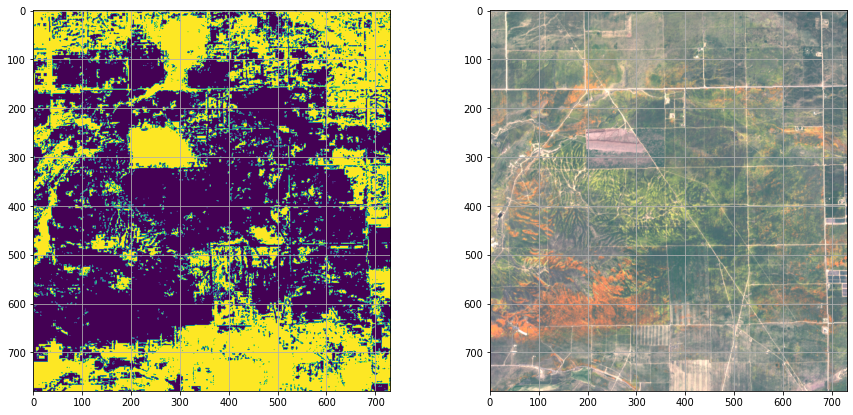

In [28]:
#look at definitely negative pixels
plot_thresh(antelope_bloom_probas, 0, 0.1, antelope_bloom);

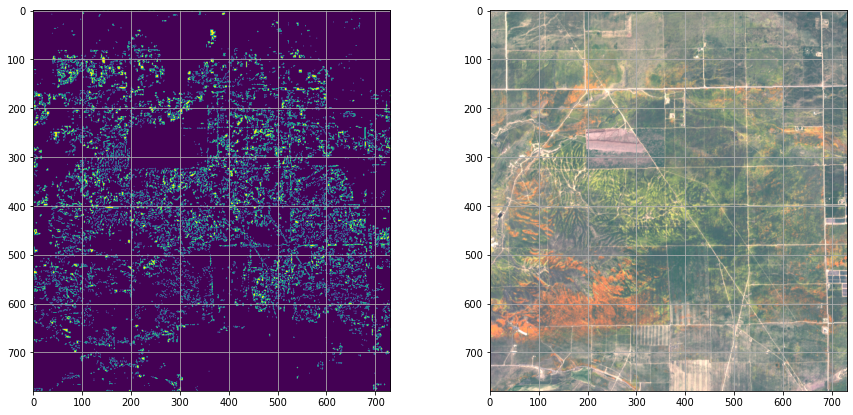

In [29]:
#look at pixels where the predictions are unsure
plot_thresh(antelope_bloom_probas, 0.4, 0.6, antelope_bloom);

#### Do the same for the nobloom image.

In [30]:
antelope_nobloom_preds, antelope_nobloom_probas = predict_pixels_probas(antelope_nobloom, scaler)

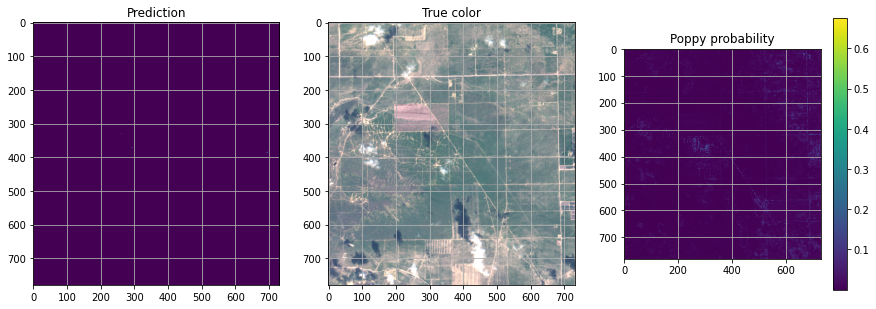

In [31]:
visual_check(antelope_nobloom_preds, antelope_nobloom_probas, antelope_nobloom)

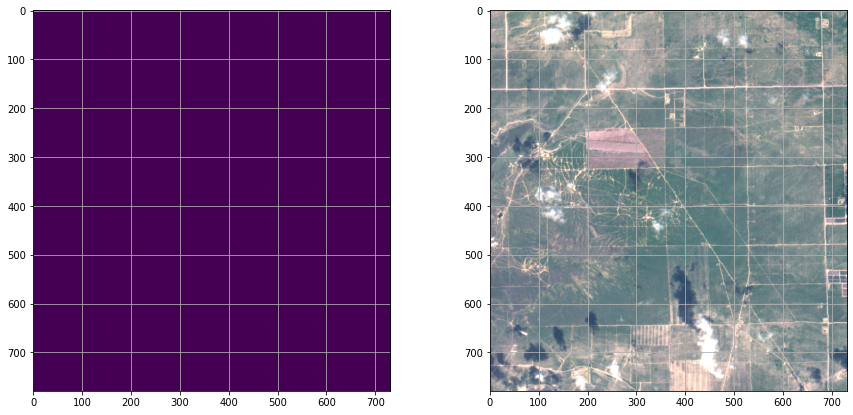

In [32]:
#look at definitely positive pixels
plot_thresh(antelope_nobloom_probas, 0.9, 1.0, antelope_nobloom);

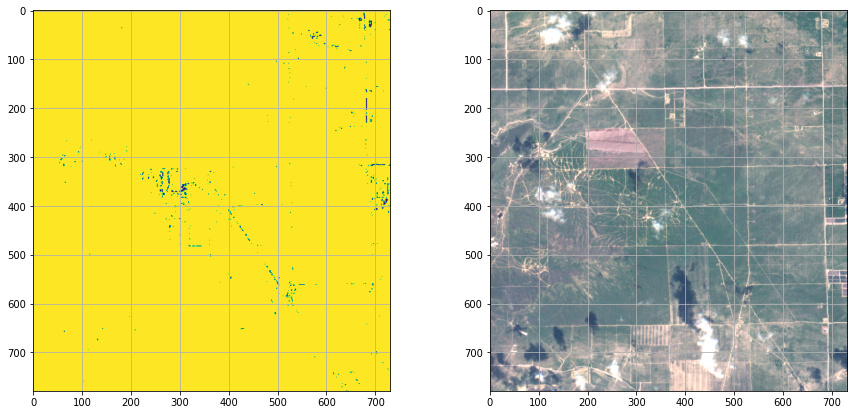

In [33]:
#look at definitely negative pixels
plot_thresh(antelope_nobloom_probas, 0, 0.1, antelope_nobloom);

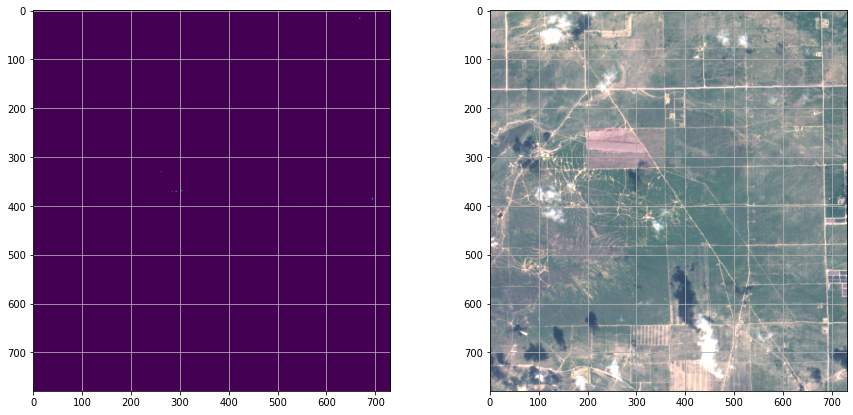

In [34]:
#look at pixels where the predictions are unsure
plot_thresh(antelope_nobloom_probas, 0.4, 0.6, antelope_nobloom);

#### Step 2 conclusion

The model does a good job of detecting poppy and not poppy pixels in the bloom image, and does not misclassify any pixels as poppy in the nobloom image. However, in the bloom image there are many pixels that the model is unsure of (prediction probability between 0.4-0.6). I will therefore hand label a subset of these uncertain pixels with their correct labels and add them to the labelled pixels that will go into the next iteration of the active learning process.

## Step 3: Update a subset of the uncertain predictions with their correct labels.

#### This is the third (and final) step in the active learning cycle.

#### 3.0 Find area where predictions were unsure but where there are no poppies

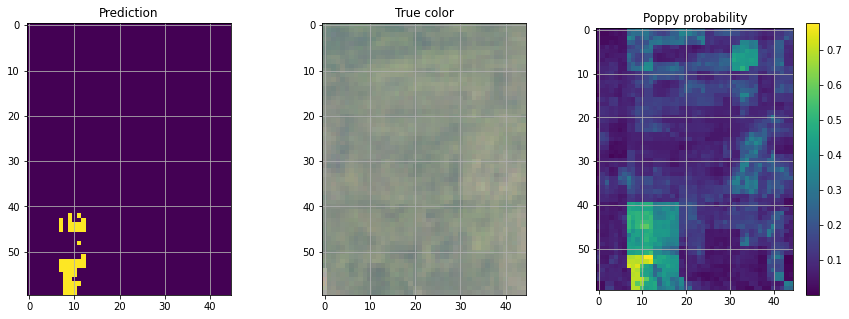

In [35]:
# Visualize area where predictions were unsure but where there are not poppies
visual_check(antelope_bloom_preds[0:60,355:400], antelope_bloom_probas[0:60,355:400], antelope_bloom[0:60,355:400])

#### 3.1 Find area where predictions were unsure but where there ARE poppies

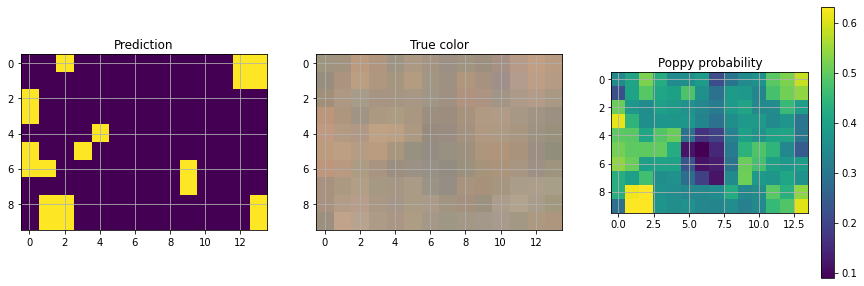

In [36]:
# Visualize area where predictions were unsure but where there ARE poppies
y1 = 215
y2 = 225
x1 = 6
x2 = 20
visual_check(antelope_bloom_preds[y1:y2,x1:x2], antelope_bloom_probas[y1:y2,x1:x2], antelope_bloom[y1:y2,x1:x2])

#### 3.2 Update labels with new labelled subset

In [37]:
#update bloom labels
antelope_bloom_labels[0:60,355:400] = 0
antelope_bloom_labels[y1:y2,x1:x2] = 1

## SECOND ITERATION

#### At this point I go back and do step 1 and step 2 with the updated labeled pixels. After examining the predictions in step 2 I decide whether the predictions are acceptable or not. If they are I exit the cycle and use the final model. If they are not I complete another iteration of the cycle.

Here I will walk through the second iteration again for demo purposes, but in reality I would just go back up to the same code above.

### Step 1

In [38]:
#get data from pixels labelled during previous iteration

#bloom image
poppy_pixdata, antelope_bloom_pixdata_nopoppy = get_pixdata(antelope_bloom_labels, antelope_bloom)

#nobloom image
tmp, antelope_nobloom_pixdata_nopoppy = get_pixdata(antelope_nobloom_labels, antelope_nobloom)

#concatenate no-poppy pixels from bloom and nobloom images
nopoppy_pixdata = np.vstack((antelope_bloom_pixdata_nopoppy, antelope_nobloom_pixdata_nopoppy))

#sanity check
print(poppy_pixdata.shape)
print(nopoppy_pixdata.shape)

(5046, 13)
(17418, 13)


In [39]:
#get features and labels
X = np.vstack((poppy_pixdata, nopoppy_pixdata))
y = np.concatenate( ( np.ones(poppy_pixdata.shape[0]), np.zeros(nopoppy_pixdata.shape[0]) ) )

#test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#fit scaler to training data and scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

#apply same transformation to test data
X_test = scaler.transform(X_test)

#initialize model and fit to training data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
clf_rf = clf_rf.fit(X_train, y_train);

#look at mean precision score
score_rf = clf_rf.score(X_test, y_test)
print(score_rf)

#predict test data
y_pred_rf = clf_rf.predict(X_test)

#precision, recall and f-scores for each class
prf_rf = precision_recall_fscore_support(y_test, y_pred_rf, average=None)
print(prf_rf)

0.9951034943245047
(array([0.99369808, 1.        ]), array([1.        , 0.97851562]), array([0.99683908, 0.98914116]), array([3469, 1024]))


### Step 2

In [40]:
antelope_bloom_preds2, antelope_bloom_probas2 = predict_pixels_probas(antelope_bloom, scaler)

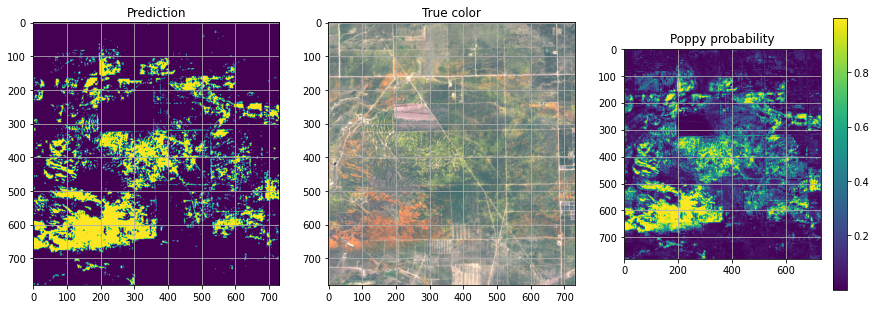

In [41]:
visual_check(antelope_bloom_preds2, antelope_bloom_probas2, antelope_bloom)

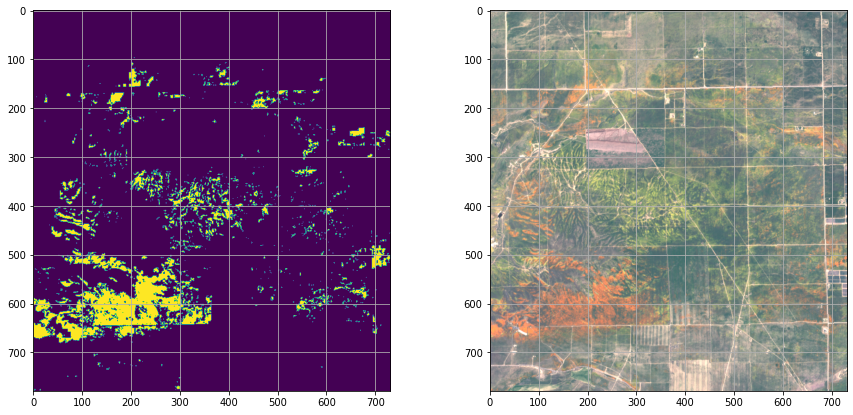

In [42]:
#look at definitely positive pixels
plot_thresh(antelope_bloom_probas2, 0.9, 1, antelope_bloom);

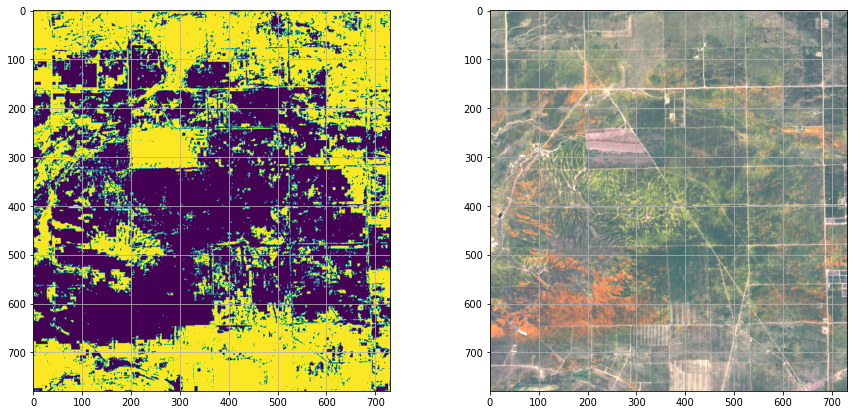

In [43]:
#look at definitely negative pixels
plot_thresh(antelope_bloom_probas2, 0, 0.1, antelope_bloom);

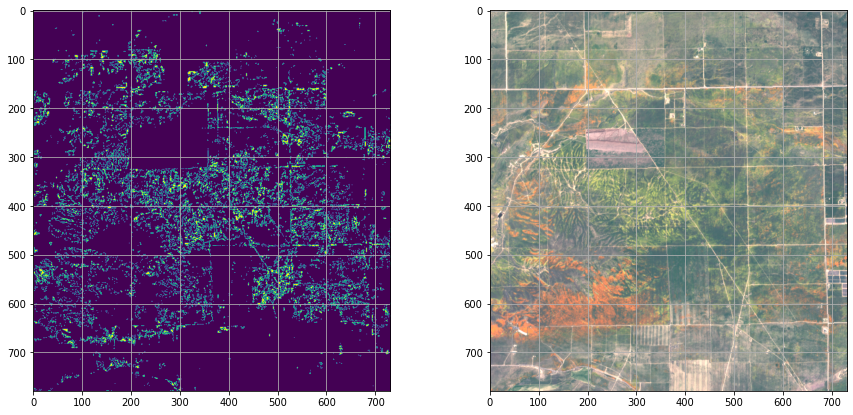

In [44]:
#look at pixels where the predictions are unsure
plot_thresh(antelope_bloom_probas2, 0.4, 0.6, antelope_bloom);

### Overall conclusion:

It's hard to see a difference between the two iterations by eye so below I've plotted the prediction probability of belonging to the poppy class for each pixel. It is a little more clear to see that on the second iteration there are fewer uncertain probabilities (that is, there fewer probabilities closer to 0.5 as opposed to closer to 0 or 1).

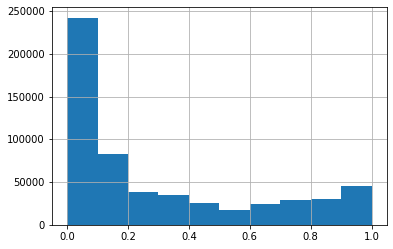

In [45]:
# prediction probabilities after first iteration
plt.hist(antelope_bloom_probas.flatten());
plt.grid()

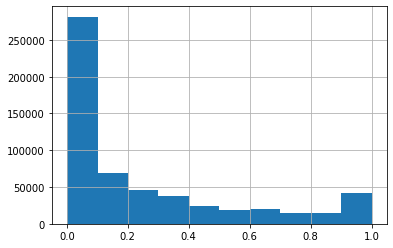

In [46]:
# prediction probabilities after second iteration
plt.hist(antelope_bloom_probas2.flatten());
plt.grid()

## Step 4: Segment predictions into fields of poppies

#### This step uses the prediction probability values of the pixels to construct a smooth map of areas that contain poppies

First, I threshold the prediction probabilities to only include pixels that the model is at least 90% certain is a poppy pixel. I then blur and threshold the resulting binary image so that the segmentation process is not affected by roads, and so that noise is decreased. I then use watershed segmentation to segment the regions.

In [47]:
from skimage import data, io, filters
from skimage.segmentation import watershed
from skimage.filters import sobel
from skimage.measure import label, regionprops

import pandas as pd
import math

In [48]:
#threshold prediction probabilities - only include highly certain predictions
probs = np.copy(antelope_bloom_probas2)
probs[probs < 0.9] = 0
probs[probs >= 0.9] = 1

#apply gaussian blur to predictions
probs_blur = filters.gaussian(probs, sigma=10)

#generate markers for poppy and no poppy pixels
markers = np.zeros_like(probs_blur)
markers[probs_blur > 0.05] = 1
markers[probs_blur > 0.2] = 2

#generate elevation map
elevation_map = sobel(probs_blur)

#watershed segmentation
segmentation = watershed(elevation_map, markers)

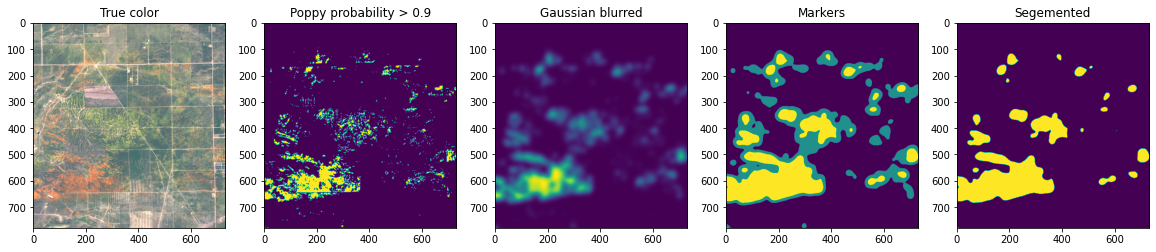

In [49]:
#visualize
fig, axs = plt.subplots(1,5, figsize=(20,4))
axs[0].imshow(np.minimum(antelope_bloom[:,:,[3,2,1]]*5, 1))
axs[1].imshow(probs)
axs[2].imshow(probs_blur)
axs[3].imshow(markers)
axs[4].imshow(segmentation);

axs[0].title.set_text('True color')
axs[1].title.set_text('Poppy probability > 0.9')
axs[2].title.set_text('Gaussian blurred')
axs[3].title.set_text('Markers')
axs[4].title.set_text('Segemented')

## Step 5: Extract information about poppy fields for app output

I get the area (number of pixels) of each poppy field, as well as the latitude and longitude of the field centroid. I then convert area into fooball field units. (Note, the first 'segment' in the list of segments corresponds to the total area of the image that does not have poppies, ie. the backgound.)

In [50]:
# get label of each segment
segs_labels = label(segmentation)

# get area and centroid of each segment
areas_list = [region.area for region in regionprops(segs_labels)]
centroids_list = [region.centroid for region in regionprops(segs_labels)]

# round and convert centroids to integer (for indexing purposes)
centroids_list = [ (int(round(cent[0])), int(round(cent[1])))  for cent in centroids_list]

In [52]:
# generate reference grid of latitudes and longitudes

coords = (-118.4, 34.72, -118.32, 34.79) # coordinates of the antelope reserve
dims = segs_labels.shape

step_x = abs((coords[0] - coords[2]) / dims[1])
step_y = abs((coords[1] - coords[3]) / dims[0])
lat, lon = np.mgrid[coords[3]:coords[1]:-step_y, coords[0]:coords[2]:step_x]

# get latitude and longitude of each centroid
centroids_lat_list = [ lat[cent[0],cent[1]] for cent in centroids_list]
centroids_long_list = [ lon[cent[0],cent[1]] for cent in centroids_list]

In [53]:
# convert area in pixels to area in football field units
ff_units = [ round(math.sqrt(area) / 10) for area in areas_list]

In [54]:
# put data into dataframe for use in app
areas = pd.DataFrame({'area':areas_list, 'centroid':centroids_list, 
                      'latitude':centroids_lat_list, 'longitude':centroids_long_list, 
                     'football_field_units':ff_units} )
areas

area    centroid   latitude   longitude  football_field_units
0   501122  (372, 382)  34.756573 -118.358194                    71
1     1292  (141, 207)  34.777330 -118.377346                     4
2      312  (132, 387)  34.778139 -118.357647                     2
3     1121  (180, 169)  34.773825 -118.381505                     3
4      100  (170, 507)  34.774724 -118.344514                     1
5     1229  (187, 466)  34.773196 -118.349001                     4
6      150  (221, 191)  34.770141 -118.379097                     1
7      741  (251, 663)  34.767445 -118.327442                     3
8      477  (281, 566)  34.764750 -118.338057                     2
9      386  (330, 557)  34.760347 -118.339042                     2
10    2609  (352, 233)  34.758370 -118.374501                     5
11    9258  (399, 350)  34.754146 -118.361696                    10
12     877   (367, 74)  34.757022 -118.391902                     3
13     151  (408, 473)  34.753338 -118.348235                     1
14    3322   (440, 81)  34.750462 -118.391135                     6
15       4  (410, 604)  34.753158 -118.333899                     0
16    1974  (505, 704)  34.744621 -118.322955                     4
17   41956  (600, 179)  34.736085 -118.380410                    20
18     339   (559, 70)  34.739769 -118.392339                     2
19     669  (576, 667)  34.738241 -118.327004                     3
20    1288  (598, 568)  34.736264 -118.337839                     4
21      52    (623, 2)  34.734018 -118.399781                     1
22      20    (776, 2)  34.720270 -118.399781                     0